In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
sys.path.insert(0, ''+'/Code/Code_ACP_article/data-objekt/')
from Utility import (get_dlogD, get_dNdD, get_dNdlogD_mean, 
                     column_names, get_dNdlogD,
                     get_dN, calc_ED, get_dlnD, get_dNdD_mean)

from Data_object import Data, load
from datetime import datetime
from datetime import timedelta

In [3]:
def plot_comp_PSD(list_data_obj, title, timestart=None, timeend=None, minbin=0, log='off',
             logx='on', quicklook=1, campaign=None):
    
    color = ['r', 'b', 'g', 'y', 'brown', 'black', 'orange']
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1],
                           height_ratios=[0.5, 5], wspace=0.4, hspace=0.1)
    axt = fig.add_subplot(gs[0, 0])
    axq = fig.add_subplot(gs[0, 1])
    ax0 = fig.add_subplot(gs[1, :])
    
    axt.text(0, 0.5, 'PSD ' + str(campaign) + '      ' + str(title), fontsize=20)
    
    if quicklook == 1:
        axt.text(0, 0.2, 'preliminary data, only for quicklook use',
                 fontsize=6)
        
    axt.axis('off')
    
    img = mpimg.imread(''+'/Code/Code_ACP_article/data-objekt/Icons/DLR.png')
    axq.imshow(img)
    axq.axis('off')
    
    max_y = 0
    for i, item in enumerate(list_data_obj):
        
        if timestart is None:
            timestart = item.t_start
        if timeend is None:
            timeend = item.t_end
        
        dNdD_m = get_dNdD_mean(item.data_df, timestart, timeend) * 1e-12
        dNdlogD_m = get_dNdlogD_mean(item.data_df, item.bin_df*1e-6, timestart, timeend) * 1e-6
        if item.probe == 'CAS':
            dNdD_m = dNdD_m[minbin:]
            dNdlogD_m = dNdlogD_m[minbin:]
            bin_df = item.bin_df[minbin:]
        else:
            bin_df = item.bin_df
        # The following creates a dataframe with bin edge to bin edge dNdlogD values 
        bin_min = list(map(float, bin_df['bin_min']))
        bin_max = list(map(float, bin_df['bin_max']))
        bin_edges = [bin_min[0]] + bin_max
        double_edge = [bin_min[0]]
        double_edge.append(bin_max[-1])
        
        for w in range(1,len(bin_edges)-1):
            double_edge.insert(w,bin_edges[w])
            double_edge.insert(w+1,bin_edges[w])
        double_edge.sort()
        bins = bin_df['bin_mid'].to_numpy()
        bins = bins
        
        dNdlogD_m_float = list(map(float, dNdlogD_m))
        dNdD_m_float = list(map(float, dNdD_m))
    
        double_dlog = dNdlogD_m_float.copy()
        double_d = dNdD_m_float.copy()
        dlog_subset = dNdlogD_m_float[0:len(dNdlogD_m_float)].copy()
        d_subset = dNdD_m_float[0:len(dNdD_m_float)].copy()
        for j in range(0,len(dlog_subset)):
            double_dlog.insert(j+j+1, dlog_subset[j])
            double_d.insert(j+j+1, d_subset[j])
    
        double_df  = pd.DataFrame({'Bin_edges': double_edge,
                                       'dNdlogD_m': double_dlog,
                                       'dNdD_m': double_d})
        
        if log == 'off':
            if max(dNdD_m) > max_y:
                max_y = max(dNdD_m)
            ax0.semilogy(double_df['Bin_edges'], double_df['dNdD_m'], 
                                drawstyle='steps-mid', color=color[i], label =item.probe)
            ax0.semilogy(bins, dNdD_m, 's', markersize=3, color=color[i])
            ax0.set_ylabel(r'dN/dD [$\mathrm{cm}^{-3} \mathrm{\mu m}^{-1}$]', fontsize=22)
            
                
        elif log == 'on':
            if max(dNdlogD_m) > max_y:
                max_y = max(dNdlogD_m[dNdlogD_m<np.inf])
                print(max_y)
            ax0.semilogy(double_df['Bin_edges'], double_df['dNdlogD_m'], 
                                drawstyle='steps-mid', color=color[i], label = item.probe)
            ax0.semilogy(bins, dNdlogD_m, 's', markersize=3, color=color[i])
            ax0.set_ylabel(r'dN/dlogD [$\mathrm{cm}^{-3}$]', fontsize=22)
        else:
            print("""
                  Only use 'on' and 'off' for log option!
                  """)
        #N = item.data_df['N'][(item.data_df.index >= timestart) &
                              #(item.data_df.index <= timeend)] *1e-6
        #N_i = item.data_df['N'][(item.data_df.index >= timestart) & (
        #item.data_df.index <= timestart + timedelta(seconds=30))] * 1e-6
        
    
    ax0.set_xlabel(r'diameter [$\mu$m]', fontsize=22)  
    ax0.set_title(timestart.strftime('%d/%m/%Y') + ' ' +
        timestart.strftime('%H:%M:%S') + '-' + timeend.strftime('%H:%M:%S'), fontsize=20)
    if logx == 'on':
        ax0.set_xscale('log')
    elif logx == 'off':
        ax0.set_xscale('linear')
    ax0.set_ylim(top=max_y+1e-1)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    ax0.legend(fontsize=18)

In [4]:
fl_nr = '04'

In [5]:
path = ''+'/Data/Data_ACP_article/Example_files_combine_probes/'
list_files = os.listdir(path)
list_files

['CDP', 'CIPG', 'CIPGPIP', 'Final_combined', 'PIP', 'README.txt']

In [6]:
# Load files
path_pip = path + '/PIP/F' + fl_nr + '/'
file_pip = os.listdir(path_pip)
PIP = load(path_pip + file_pip[0])

path_cip = path + '/CIPG/F' + fl_nr + '/'
file_cip = os.listdir(path_cip)
CIPG = load(path_cip + file_cip[0])

path_cdp = path + '/CDP/F' +  fl_nr + '/'
file_cdp = os.listdir(path_cdp)
CDP = load(path_cdp + file_cdp[0])

path_cippip = path + 'CIPGPIP/F' + fl_nr + '/'
file_cippip = os.listdir(path_cippip)
CIPPIP = load(path_cippip + file_cippip[0])

0.18106478856083882


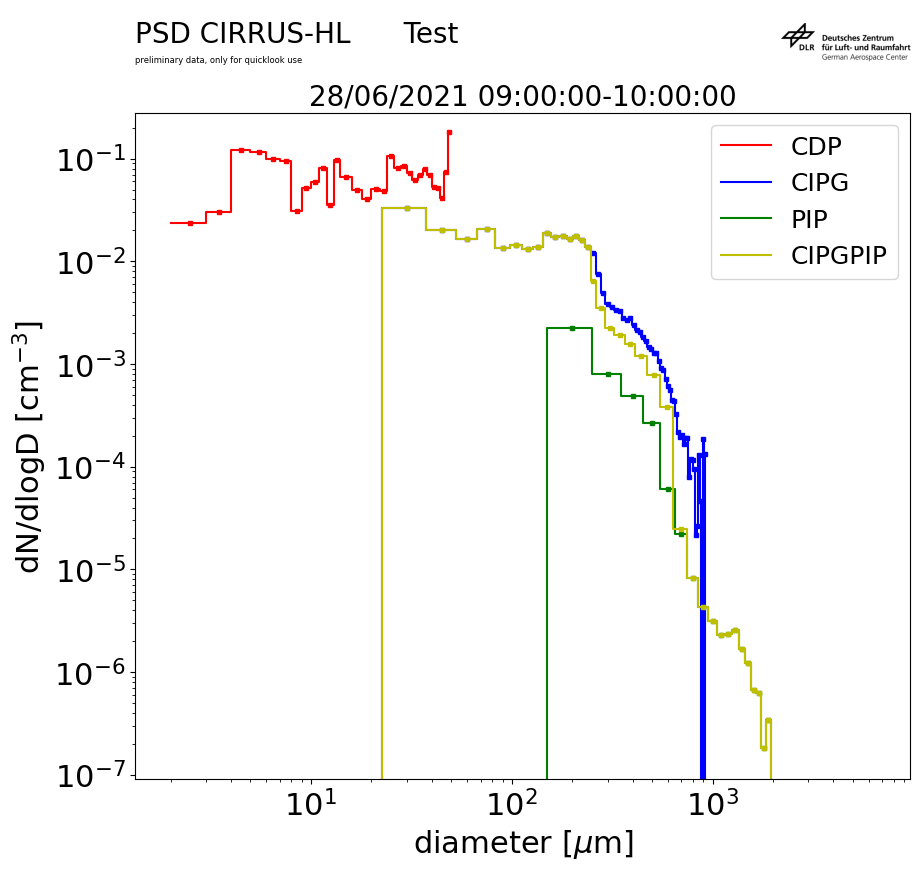

In [7]:
t_start = datetime(2021, 6, 28, 9, 0, 0)
t_end = datetime(2021, 6, 28, 10, 0, 0)
plot_comp_PSD([CDP, CIPG, PIP, CIPPIP], 'Test', t_start, t_end, log='on', campaign='CIRRUS-HL')

In [7]:
seq = [1]*4 + [2]*2 + [4]*2 + [6]*3

test_df = CDP.data_df
test_bin = CDP.bin_df[:24]
dNdD_cols = test_df.loc[:, 'dNdD_001':].columns

new_dNdD = np.zeros((len(test_df), len(seq)))
bin_joint = pd.DataFrame(columns=test_bin.columns, index=np.arange(1, len(seq)+1))
last = 1
for i,item in enumerate(seq):
    sume_dN = 0
    sume_dD = 0
    #print(i, item)
    for j in range(last, len(test_bin)):
        sume_dN = sume_dN + test_df[dNdD_cols[j-1]]*test_bin.loc[j].bin_width
        sume_dD = sume_dD + test_bin.loc[j].bin_width
        #print(j, sume_dD)
        if sume_dD == item:
            new_dNdD[:, i] = sume_dN/sume_dD
            bin_joint.bin_min.loc[i + 1] = test_bin.bin_min.loc[last]
            bin_joint.bin_max.loc[i + 1] = test_bin.bin_max.loc[j]
            bin_joint.bin_width.loc[i + 1] = item
            bin_joint.bin_mid.loc[i + 1] = (test_bin.bin_max.loc[j] + test_bin.bin_min.loc[last]) / 2 
            if j==(len(test_bin)-1):
                new_dNdD[:, i] = (sume_dN + test_df[dNdD_cols[j-1]]*1.5)/(sume_dD+1.5)
                bin_joint.bin_min.loc[i + 1] = test_bin.bin_min.loc[last]
                bin_joint.bin_max.loc[i + 1] += 1.5
                bin_joint.bin_width.loc[i + 1] +=  1.5
                bin_joint.bin_mid.loc[i + 1] = (bin_joint.bin_max.loc[i+1] + bin_joint.bin_min.loc[i+1] ) / 2
                #print(bin_joint.loc[i + 1])
                break
            
            last = j+1
            break
        

In [8]:
def column_names(bin_df, name1, name2):

    length = len(bin_df)

    dn_names = []
    dNdD_names = []
    for i in range(1,length + 1):
        if i < 10:
            dn_names.append(name1+'_00' + str(i))
            dNdD_names.append(name2+'_00' + str(i))
        elif 10 <= i < 100:
            dn_names.append(name1+'_0' + str(i))
            dNdD_names.append(name2+'_0' + str(i))
        elif i >= 100:
            dn_names.append(name1+'_' + str(i))
            dNdD_names.append(name2+'_' + str(i))

    return dn_names, dNdD_names

In [9]:
dn_names, dNdD_names = column_names(bin_joint, 'dn', 'dNdD')

In [10]:
dNdD_df = pd.DataFrame(new_dNdD, columns=dNdD_names, index = CDP.data_df.index)

In [11]:
dNdD_df = dNdD_df.resample('1S').mean()

In [12]:
CDP_new = Data()
CDP_new.data_df = dNdD_df
CDP_new.bin_df = bin_joint

In [13]:
dNdD_cippip = get_dNdD(CIPPIP.data_df)

In [14]:
time_start = min(CDP_new.data_df.index[0], CIPPIP.data_df.index[0])
time1 = max(CDP_new.data_df.index[0], CIPPIP.data_df.index[0])
time2 = min(CDP_new.data_df.index[-1], CIPPIP.data_df.index[-1])
time_end = max(CDP_new.data_df.index[-1], CIPPIP.data_df.index[-1])
print(time_start, time1, time2, time_end)

2021-06-28 07:53:38 2021-06-28 07:53:51 2021-06-28 15:13:18 2021-06-28 15:33:00


In [15]:
bin_df_total = pd.concat([CDP_new.bin_df, CIPPIP.bin_df[2:]], ignore_index=True)

In [16]:
bin_df_total.index = np.arange(1, len(bin_df_total)+1)

In [17]:
n_columns = len(dNdD_cippip.columns[2:]) + len(dNdD_df.columns)

In [18]:
dNdD_names, dNdlogD_names = column_names(bin_df_total, 'dNdD', 'dNdlogD')

In [19]:
dNdD_total = pd.DataFrame(columns=dNdD_names, index = np.arange(time_start, time_end+timedelta(seconds=1) , timedelta(seconds=1)))

In [20]:
dNdD_total.loc[time1:time2, 'dNdD_001':dNdD_names[len(dNdD_df.columns)-1]] = dNdD_df.loc[time1:time2].values
dNdD_total.loc[time1:time2, dNdD_names[len(dNdD_df.columns)]:] = dNdD_cippip.loc[time1:time2, 'dNdD_003':].values
if time_start == CIPPIP.data_df.index[0]:
    dNdD_total.loc[time_start:time1, dNdD_names[len(dNdD_df.columns)]:] = dNdD_cippip.loc[time_start:time1, 'dNdD_003':].values
else:
    dNdD_total.loc[time_start:time1, 'dNdD_001':dNdD_names[len(dNdD_df.columns)-1]] = dNdD_df.loc[time_start:time1].values
if time_end == CIPPIP.data_df.index[-1]:
    dNdD_total.loc[time2:, dNdD_names[len(dNdD_df.columns)]:] = dNdD_cippip.loc[time2:time_end, 'dNdD_003':].values
else:
    dNdD_total.loc[time2:, 'dNdD_001':dNdD_names[len(dNdD_df.columns)-1]] = dNdD_df.loc[time2:time_end].values

In [21]:
def calc_IWC(data_df, bin_df):
    
    dN = get_dN(data_df, bin_df)
    IWC_i = np.empty(np.shape(dN))
    IWC = np.empty(np.shape(dN)[0])
    for i in range(np.shape(dN)[0]):           # time axes
        IWC_i[i] = dN[i] * (0.00528*(bin_df.bin_mid*100)**2.1)*1e-3
        IWC[i] = np.nansum(IWC_i[i])

    return IWC, IWC_i

In [22]:
dN = get_dN(dNdD_total, bin_df_total*1e-6)
N = dN.sum(axis=1)
ED = calc_ED(dNdD_total, bin_df_total*1e-6)
IWC, IWC_i = calc_IWC(dNdD_total, bin_df_total*1e-6)

In [23]:
data_df = dNdD_total
data_df['N'] = N
data_df['ED'] = ED
data_df['IWC'] = IWC
data_df['Cloud_flag'] = data_df['IWC'].apply(lambda x: 1 if x > 0 else 0)
data_df['MVD'] = 0
data_df['LWC'] = 0

In [24]:
Combi = Data()
Combi.data_df = data_df
Combi.bin_df = bin_df_total
Combi.t_start = data_df.index[0]
Combi.t_end = data_df.index[-1]
Combi.type = 'OAP'
Combi.probe = 'CDPCIPGPIP'

D:/TUDelft/Repository/Code/data-objekt\Plots.py:279: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(data_df.index, bin_edges, dNdlogD, norm=LogNorm(vmin=t[0], vmax=t[-1]), cmap=cm.jet)


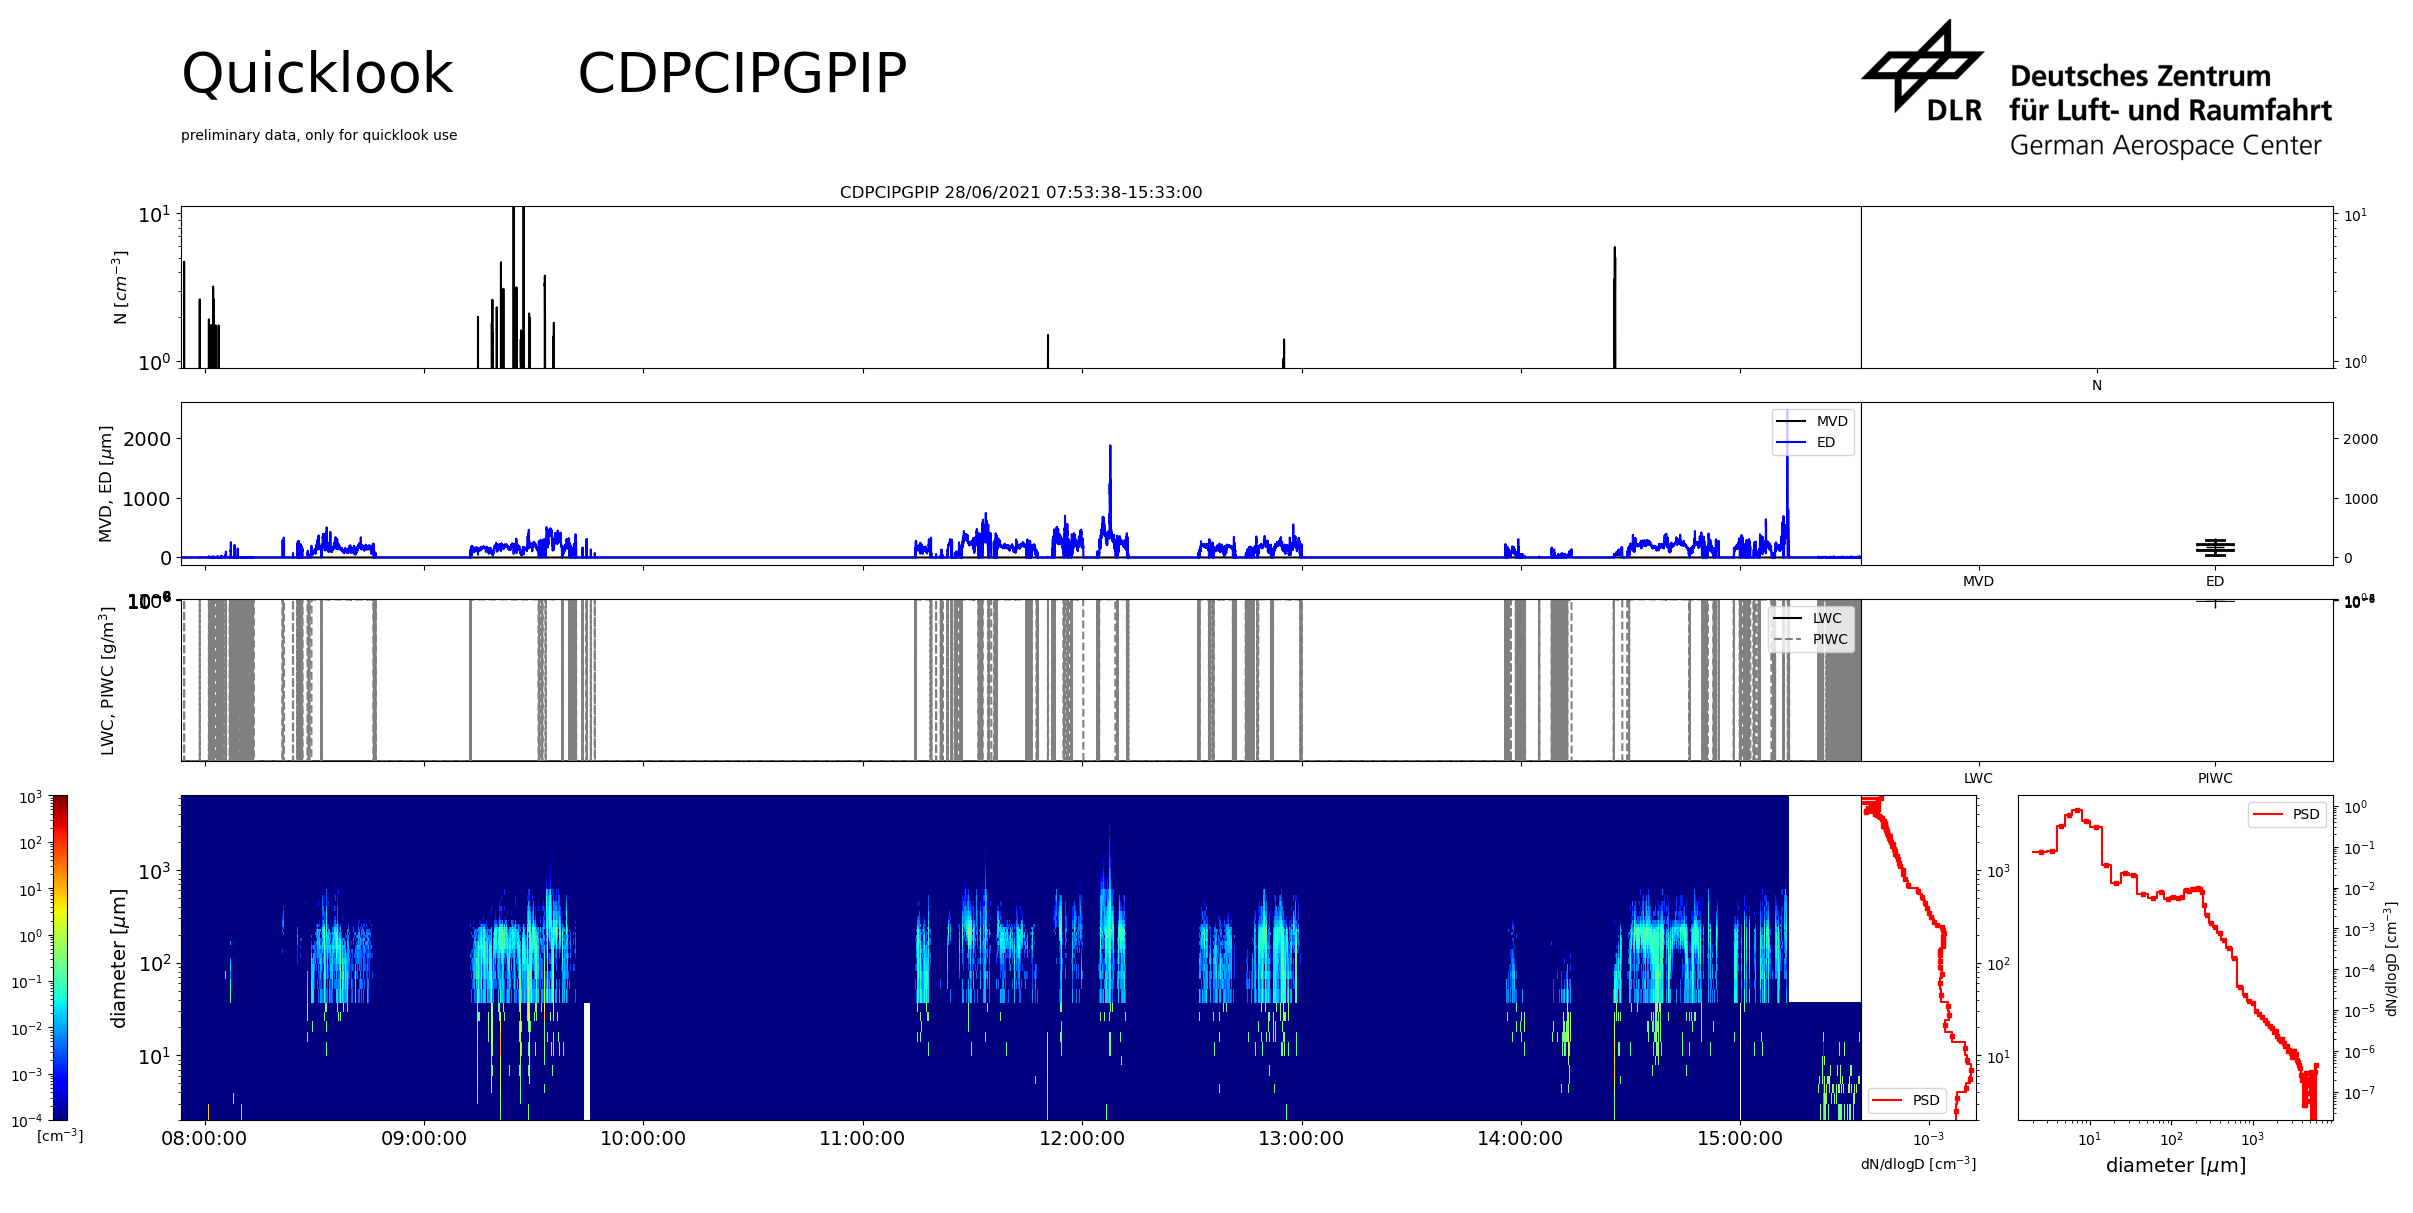

In [25]:
Combi.plot_quicklook(log='on')

0.11112930903712206


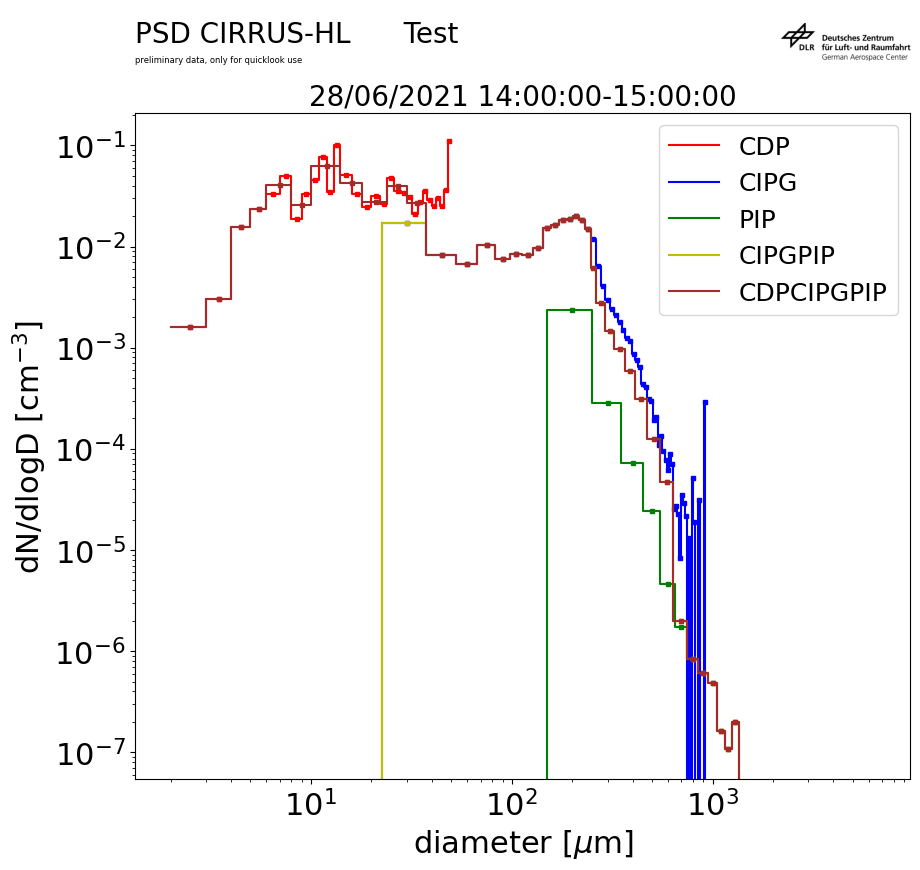

In [26]:
t_start = datetime(2021, 6, 28, 14, 0, 0)
t_end = datetime(2021, 6, 28, 15, 0, 0)
plot_comp_PSD([CDP, CIPG, PIP, CIPPIP, Combi], 'Test', t_start, t_end, log='on', campaign='CIRRUS-HL')

In [27]:
name_dir = path + 'Final_combined/'

In [28]:
Combi.name = 'Combi'
Combi.max_bin = Combi.bin_df.index[-1]
Combi.min_bin = Combi.bin_df.index[0]
Combi.path = name_dir + 'F'+fl_nr
Combi.save()

MVD=0.0


D:/TUDelft/Repository/Code/data-objekt\Plots.py:279: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax0.pcolormesh(data_df.index, bin_edges, dNdlogD, norm=LogNorm(vmin=t[0], vmax=t[-1]), cmap=cm.jet)
